## LIBRERÍAS

In [62]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import time as tm
import re
import xgboost

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score #multiclase, complicado la ROC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

## DATA
Dividí desde el inciio en X_train y X_test. Estos son los datsets que he obtenido después de toda la preparación de los datos.

In [3]:
X = pd.read_csv('/Users/gabrielarodrigocastrillo/Desktop/The_Bridge/Data_Science/COPIA_Repositorio/03-Machine_Learning/Proyecto_ML/SRC/data/train/train_procesado.csv')
X_PCA = pd.read_csv('/Users/gabrielarodrigocastrillo/Desktop/The_Bridge/Data_Science/COPIA_Repositorio/03-Machine_Learning/Proyecto_ML/SRC/data/train/train_proces_PCA.csv')

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   danceability               1173 non-null   float64
 1   energy                     1173 non-null   float64
 2   speechiness                1173 non-null   float64
 3   acousticness               1173 non-null   float64
 4   instrumentalness           1173 non-null   float64
 5   liveness                   1173 non-null   float64
 6   valence                    1173 non-null   float64
 7   tempo_confidence           1173 non-null   float64
 8   time_signature_confidence  1173 non-null   float64
 9   key_confidence             1173 non-null   float64
 10  mode                       1173 non-null   int64  
 11  mode_confidence            1173 non-null   float64
 12  al_type_compilation        1173 non-null   int64  
 13  al_type_single             1173 non-null   int64

Parece que 'mode' puede estar afectando con correlación al target. Pruebo a quitarla.

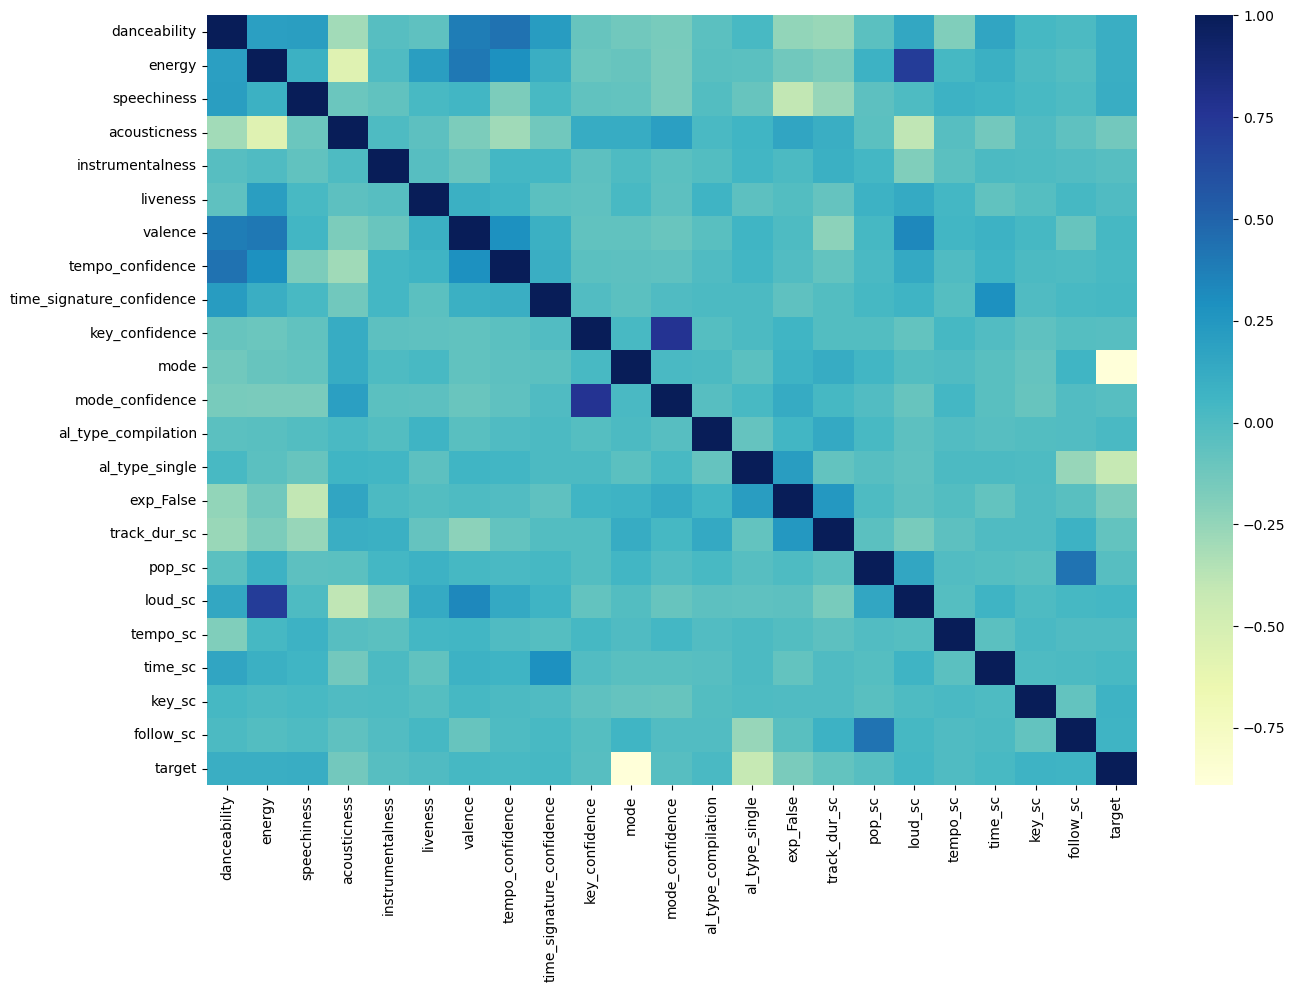

In [5]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.heatmap(X.corr(), ax=ax, cmap="YlGnBu");

Parece que las PCA1 y PCA2 pueden estar haciendo que me overfittee el modelo, las quito.

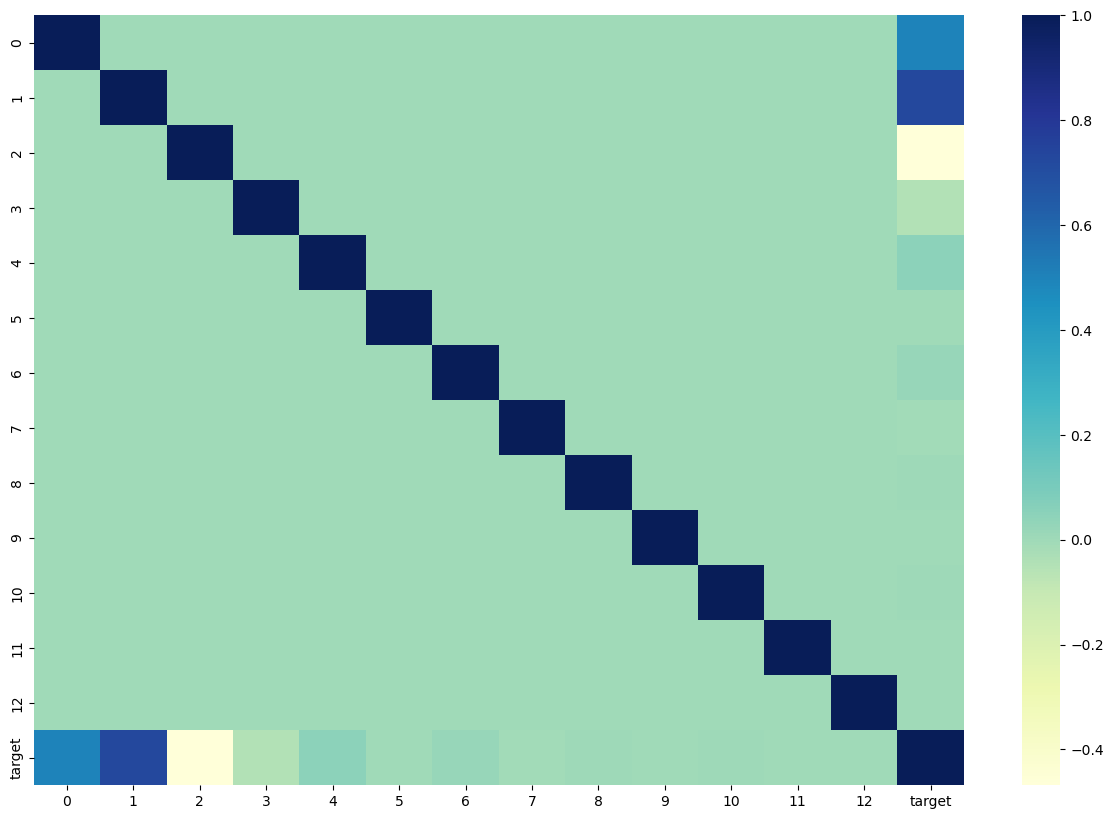

In [6]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.heatmap(X_PCA.corr(), ax=ax, cmap="YlGnBu");

In [7]:
X_PCA.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       'target'],
      dtype='object')

In [8]:
y_train = X['target']

X_train = X.copy()
X_train = X_train.drop(columns=['target','mode','energy'])

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   danceability               1173 non-null   float64
 1   speechiness                1173 non-null   float64
 2   acousticness               1173 non-null   float64
 3   instrumentalness           1173 non-null   float64
 4   liveness                   1173 non-null   float64
 5   valence                    1173 non-null   float64
 6   tempo_confidence           1173 non-null   float64
 7   time_signature_confidence  1173 non-null   float64
 8   key_confidence             1173 non-null   float64
 9   mode_confidence            1173 non-null   float64
 10  al_type_compilation        1173 non-null   int64  
 11  al_type_single             1173 non-null   int64  
 12  exp_False                  1173 non-null   int64  
 13  track_dur_sc               1173 non-null   float

In [10]:
len(y_train)

1173

In [11]:
y_train.value_counts(normalize=True)

0    0.306053
2    0.265985
1    0.248082
3    0.179881
Name: target, dtype: float64

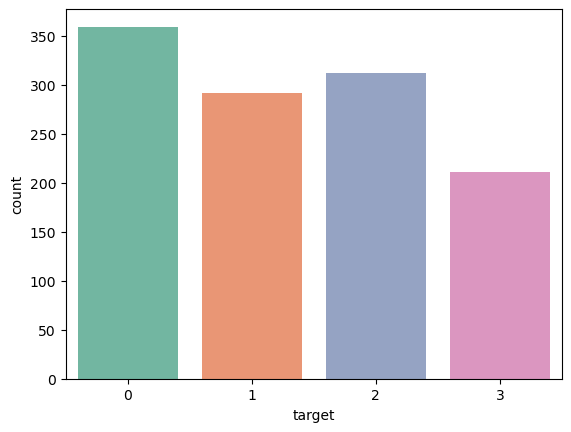

In [12]:
sns.countplot(x=y_train, palette='Set2');

In [13]:
y_PCA_train = X_PCA['target']

X_PCA_train = X_PCA.copy()
X_PCA_train = X_PCA_train.drop(columns=['target','1','2']) #correlación

In [14]:
X_PCA_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1173 non-null   float64
 1   3       1173 non-null   float64
 2   4       1173 non-null   float64
 3   5       1173 non-null   float64
 4   6       1173 non-null   float64
 5   7       1173 non-null   float64
 6   8       1173 non-null   float64
 7   9       1173 non-null   float64
 8   10      1173 non-null   float64
 9   11      1173 non-null   float64
 10  12      1173 non-null   float64
dtypes: float64(11)
memory usage: 100.9 KB


In [15]:
y_PCA_train.value_counts(normalize=True)

0    0.306053
2    0.265985
1    0.248082
3    0.179881
Name: target, dtype: float64

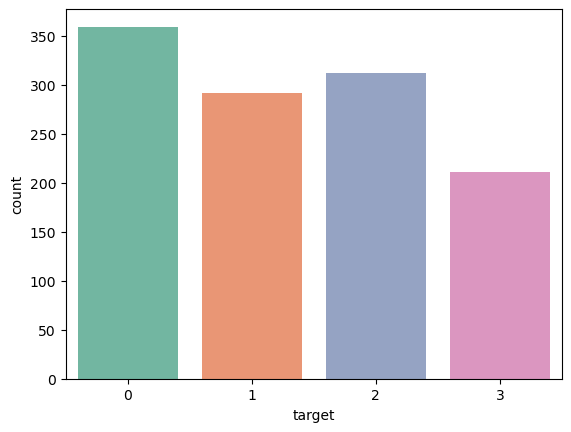

In [16]:
sns.countplot(x=y_PCA_train, palette='Set2');

## MODELOS
Seleccionar tipo de modelos para comparar cuál funciona mejor.  
Modelos básicos, sin optimizar hiperparámetros ni nada.

In [17]:
t_zero = tm.time()

In [18]:
list_models_names = ["Regresion Logistica","Arbol de Decision","Random Forest", "XGBoost"]
list_models = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier]
classification_models = { model_name:make_pipeline(model() if "Regresion" not in model_name else model(max_iter = 1000)) for model_name,model in \
                 zip(list_models_names, list_models)}

In [19]:
logreg = LogisticRegression(penalty='l1', solver='saga',max_iter=1000)
model1 = logreg.fit(X_train, y_train)

print("TRAIN")
print("---------------")
print(classification_report(y_train, model1.predict(X_train)))

TRAIN
---------------
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       359
           1       0.62      0.82      0.71       291
           2       0.56      0.46      0.51       312
           3       0.56      0.32      0.41       211

    accuracy                           0.59      1173
   macro avg       0.58      0.57      0.56      1173
weighted avg       0.59      0.59      0.58      1173



¿Por qué solo me cambia en la regresión?

In [20]:
logreg = LogisticRegression()
model1_PCA = logreg.fit(X_PCA_train, y_PCA_train)

print("TRAIN PCA")
print("---------------")
print(classification_report(y_PCA_train, model1_PCA.predict(X_PCA_train)))

TRAIN PCA
---------------
              precision    recall  f1-score   support

           0       0.59      0.79      0.68       359
           1       0.46      0.55      0.50       291
           2       0.37      0.16      0.23       312
           3       0.51      0.49      0.50       211

    accuracy                           0.51      1173
   macro avg       0.48      0.50      0.48      1173
weighted avg       0.49      0.51      0.48      1173



In [21]:
tree = DecisionTreeClassifier()
model2 = tree.fit(X_train, y_train)

print("TRAIN")
print("---------------")
print(classification_report(y_train, model2.predict(X_train)))

TRAIN
---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       1.00      1.00      1.00       291
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       211

    accuracy                           1.00      1173
   macro avg       1.00      1.00      1.00      1173
weighted avg       1.00      1.00      1.00      1173



In [22]:
tree2=DecisionTreeClassifier()
model2_PCA = tree2.fit(X_PCA_train, y_PCA_train)

print("TRAIN PCA")
print("---------------")
print(classification_report(y_PCA_train, model2_PCA.predict(X_PCA_train)))

TRAIN PCA
---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       1.00      1.00      1.00       291
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       211

    accuracy                           1.00      1173
   macro avg       1.00      1.00      1.00      1173
weighted avg       1.00      1.00      1.00      1173



In [23]:
rfc = RandomForestClassifier()
model3 = rfc.fit(X_train, y_train)

print("TRAIN")
print("---------------")
print(classification_report(y_train, model3.predict(X_train)))

TRAIN
---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       1.00      1.00      1.00       291
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       211

    accuracy                           1.00      1173
   macro avg       1.00      1.00      1.00      1173
weighted avg       1.00      1.00      1.00      1173



In [24]:
rfc = RandomForestClassifier()
model3_PCA = rfc.fit(X_PCA_train, y_PCA_train)

print("TRAIN PCA")
print("---------------")
print(classification_report(y_PCA_train, model3_PCA.predict(X_PCA_train)))

TRAIN PCA
---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       1.00      1.00      1.00       291
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       211

    accuracy                           1.00      1173
   macro avg       1.00      1.00      1.00      1173
weighted avg       1.00      1.00      1.00      1173



In [25]:
xgbc = XGBClassifier()
model4 = xgbc.fit(X_train, y_train)

print("TRAIN")
print("---------------")
print(classification_report(y_train, model4.predict(X_train)))

TRAIN
---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       1.00      1.00      1.00       291
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       211

    accuracy                           1.00      1173
   macro avg       1.00      1.00      1.00      1173
weighted avg       1.00      1.00      1.00      1173



In [26]:
xgbc = XGBClassifier()
model4_PCA = xgbc.fit(X_PCA_train, y_PCA_train)

print("TRAIN PCA")
print("---------------")
print(classification_report(y_PCA_train, model4_PCA.predict(X_PCA_train)))

TRAIN PCA
---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       1.00      1.00      1.00       291
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       211

    accuracy                           1.00      1173
   macro avg       1.00      1.00      1.00      1173
weighted avg       1.00      1.00      1.00      1173



## CROSS VALIDATION

*Comentario Jaime*:  
O mejor, después de entrar cada modelo usa el cross validation
Es decir cross_val_score(modelo, X_train,y_train, cv= 3, score = "accuracy") para cada modelo, te va a dar un array con 3 valore (porque cv = 3), haces la media y ese es el valor que debes comparar entre todos....

In [27]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

Aquí hago el cross_val_score con X_train a secas.   
El modelo que mejor resultado me da: **XGBoost**, **RandomForest**

In [28]:
cv_lg = cross_val_score(model1, X_train,y_train,cv=3,scoring='accuracy')
lg_mean = np.mean(cv_lg)

cv_tree = cross_val_score(model2, X_train,y_train,cv=3,scoring='accuracy')
tree_mean = np.mean(cv_tree)

cv_rf = cross_val_score(model3, X_train,y_train,cv=3,scoring='accuracy')
rf_mean = np.mean(cv_rf)

cv_xgb = cross_val_score(model4, X_train,y_train,cv=3,scoring='accuracy')
xgb_mean = np.mean(cv_xgb)

lg_mean,tree_mean, rf_mean, xgb_mean

(0.5558397271952259,
 0.5583972719522592,
 0.6061381074168798,
 0.6138107416879796)

Aquí cross_val_score con PCA components.   
Modelos que mejor funcionan: **XGBoost**, **RandomForest** (el tree esta overfitteando 100%)

In [29]:
# Pruebo lo mismo con PCA
cv_lg_pca = cross_val_score(model1_PCA, X_PCA_train,y_PCA_train,cv=3,scoring='accuracy')
lg_mean_pca = np.mean(cv_lg_pca)

cv_tree_pca = cross_val_score(model2_PCA, X_PCA_train,y_PCA_train,cv=3,scoring='accuracy')
tree_mean_pca = np.mean(cv_tree_pca)

cv_rf_pca = cross_val_score(model3_PCA, X_PCA_train,y_PCA_train,cv=3,scoring='accuracy')
rf_mean_pca = np.mean(cv_rf_pca)

cv_xgb_pca = cross_val_score(model4_PCA, X_PCA_train,y_PCA_train,cv=3,scoring='accuracy')
xgb_mean_pca = np.mean(cv_xgb_pca)

lg_mean_pca,tree_mean_pca, rf_mean_pca, xgb_mean_pca

(0.5063938618925831, 0.9104859335038363, 0.895993179880648, 0.9335038363171355)

## GRID SEARCH

*Comentario Jaime*   
Si cross_val_score sale mejor en alguno de los modelos, quédate ese y lo pruebas contra el X_test

In [40]:
#XGBoost sin PCA
param_grid = {'n_estimators':[100,150,200,300],
              'eta':[0.001,0.005,0.01],
              'min_child_weight':[1,2,3],
              'max_depth':[3,4,5,6],
              'gamma':[0.05,0.5,1,2,3]}
grid_search_xgb = GridSearchCV(model4, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

In [41]:
grid_search_xgb.fit(X_train, y_train)

grid_search_xgb.best_params_

{'eta': 0.001,
 'gamma': 3,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 100}

In [42]:
grid_search_xgb.best_estimator_.score(X_train, y_train)

0.8209718670076727

Claramente, está overfitteando

In [43]:
best_xgb = grid_search_xgb.best_estimator_
predictions = best_xgb.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.58      0.85      0.69        87
           1       0.59      0.86      0.70        72
           2       0.59      0.26      0.36        73
           3       0.66      0.31      0.42        62

    accuracy                           0.59       294
   macro avg       0.60      0.57      0.54       294
weighted avg       0.60      0.59      0.55       294



In [42]:
#Random Forest PCA
params = {'n_estimators':[100,150,200,250,300],
          'max_features':[2,3,5,8,9],
          'max_depth': [3, 6, 7,10],
          'min_samples_split': np.arange(2, 20, 2),
          'min_samples_leaf': np.arange(1, 20, 2)}

grid_search_rfc =GridSearchCV(model3_PCA, params, cv=5,scoring='accuracy', n_jobs=-1)

In [43]:
grid_search_rfc.fit(X_PCA_train,y_PCA_train)
grid_search_rfc.best_params_

{'max_depth': 10,
 'max_features': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 250}

In [44]:
grid_search_rfc.best_estimator_.score(X_PCA_train, y_PCA_train)

1.0

In [56]:
best_rfc = grid_search_rfc.best_estimator_
predictions1 = best_rfc.predict(X_PCA_test)
print(classification_report(y_PCA_test,predictions1))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        87
           1       0.88      0.92      0.90        72
           2       0.92      0.92      0.92        73
           3       0.98      0.95      0.97        62

    accuracy                           0.94       294
   macro avg       0.94      0.94      0.94       294
weighted avg       0.94      0.94      0.94       294



In [30]:
#intentar gcv con xgboost y PCA
params_grid = {'n_estimators':[10,30,50,100,150,200,300],
              'eta':[0.001,0.005,0.01],
              'min_child_weight':[0.05,0.1,0.5,1,2,3],
              'max_depth':[3,4,5,6]}
grid_search_xgb2 = GridSearchCV(model4_PCA, params_grid, cv=5, scoring="accuracy", n_jobs=-1)

In [31]:
grid_search_xgb2.fit(X_PCA_train, y_PCA_train)

grid_search_xgb2.best_params_

{'eta': 0.001, 'max_depth': 3, 'min_child_weight': 0.05, 'n_estimators': 300}

In [38]:
grid_search_xgb2.best_estimator_.score(X_PCA_train, y_PCA_train)

1.0

In [39]:
best_xgb2 = grid_search_xgb2.best_estimator_
predictions2 = best_xgb2.predict(X_PCA_test)
print(classification_report(y_PCA_test,predictions2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       0.94      0.94      0.94        72
           2       0.95      0.97      0.96        73
           3       1.00      0.97      0.98        62

    accuracy                           0.97       294
   macro avg       0.97      0.97      0.97       294
weighted avg       0.97      0.97      0.97       294



Estoy intentando usar ste código para comaprarlos con val_score pero al ser multicalse me devuelve ese error, que no consigo solucionar. Por eso he hecho todo lo de antes a manubrio

Regresion Logistica


TypeError: only size-1 arrays can be converted to Python scalars

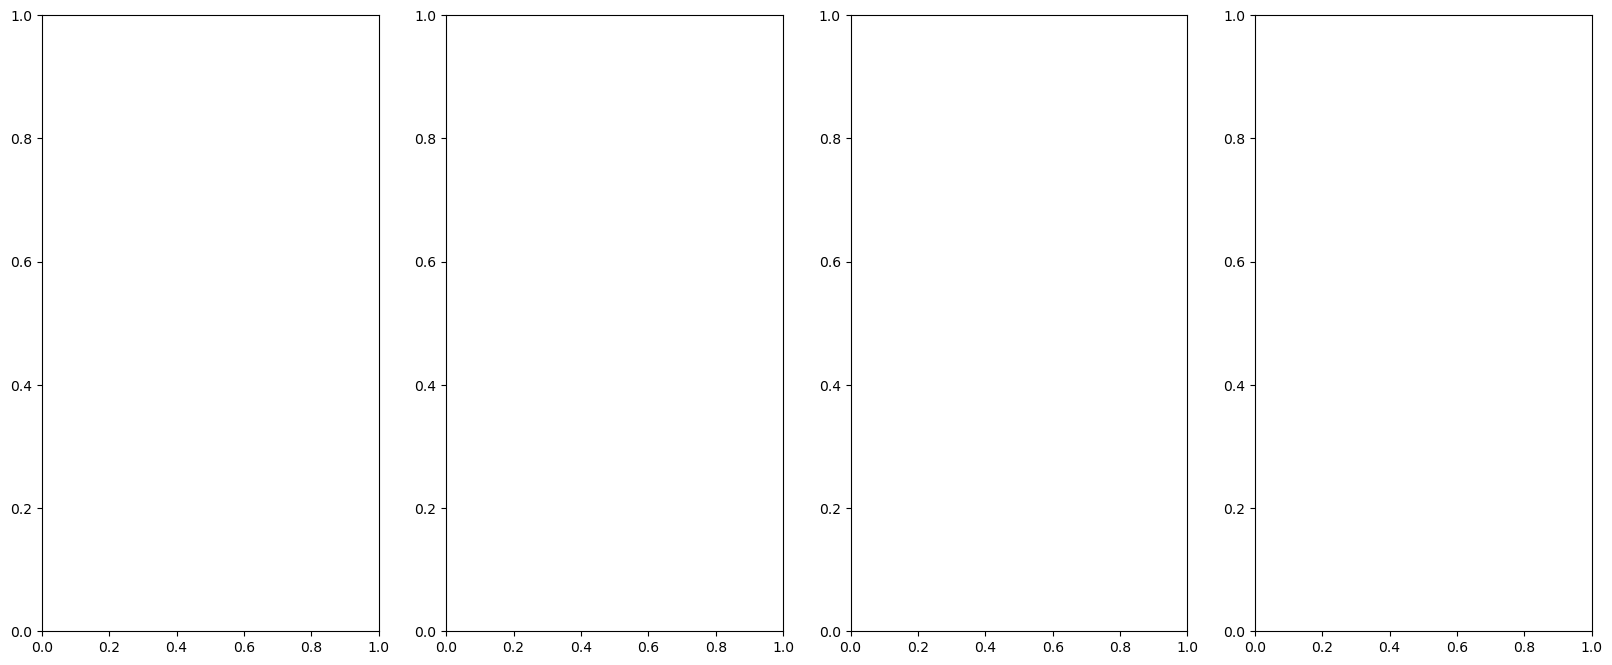

In [93]:
results = {}
best_name = "None"
best = None
indice = 0
fig, axs = plt.subplots(nrows=1, ncols=len(classification_models), figsize=(20, 8))
num_cv = 10
#for model_name,modelo in [(clave, valor) for clave,valor in classification_models.items() if "Logist" not in clave]:
for model_name,modelo in classification_models.items():
    t_zero = tm.time()
    print(model_name)
    results[model_name] = {}
    modelo.fit(X_train, y_train)
    if num_cv < 2:
        predictions = modelo.predict(X_train)
        
    else:
        predictions = cross_val_predict(modelo,X_train, y_train, cv = num_cv, \
                                                method = "predict")
    # Metrics
    results[model_name]["predictions"] = predictions.copy()
    for metric,evaluator in zip(["Precision","Recall","Accuracy","f1_score"],[precision_score, recall_score, \
                                                                        accuracy_score, f1_score]):
        results[model_name][metric] = evaluator(y_train,(predictions),average=None)
        print("%s: %.2f" %(metric, (results[model_name][metric])))
    #plt.rc('font', size=10)
    #ConfusionMatrixDisplay.from_predictions(y_train,predictions, ax=axs[indice]) 
    #axs[indice].set_title(model_name)
    #results[model_name] = recall_score(y_train_NBA, housing_predictions)
    #print(results[model_name])
    #best = results[model_name] if best == None else best
    #best_name = model_name if results[model_name] < best else best_name
    #best = results[model_name] if results[model_name] > best else best
    #print("Modelo <{}> -> Precision: {}, training_time: {}".format(model_name, results[model_name], tm.time() - t_zero))
    print("Training time: %.2f\n" %(tm.time() - t_zero))
    print("#######\n")
    indice += 1
#print("Best: ",best_name)
#plt.show()

He intentado eso otro, pero igual, sólo me deja hacerlo con 'accuracy' por ser multiclase. Tampoco consigo solucionarlo.

In [66]:
def model(list_models, X = None,y = None, cv = 10, scoring = "recall"):
    resultados = {}
    X_train = X
    for model in list_models:
        list_models_names = re.match("<class '(.*?)'>",str(model)).group(1).split(".")[-1]
        resultados[list_models_names] = cross_val_score(model(), X_train,y, cv = cv, scoring = scoring)
        print("<%s>: %.4f" %(list_models_names,np.mean(resultados[list_models_names])))
    return resultados

In [95]:
model(list_models=list_models, X=X_train, y=y_train)

/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/opt/anaconda3/

<LogisticRegression>: nan
<DecisionTreeClassifier>: nan


/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/opt/anaconda3/

<RandomForestClassifier>: nan


/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/opt/anaconda3/

<XGBClassifier>: nan


/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/opt/anaconda3/

{'LogisticRegression': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'DecisionTreeClassifier': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'RandomForestClassifier': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'XGBClassifier': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}

## CARGO TEST

In [33]:
test = pd.read_csv('/Users/gabrielarodrigocastrillo/Desktop/The_Bridge/Data_Science/COPIA_Repositorio/03-Machine_Learning/Proyecto_ML/SRC/data/test/test_procesado.csv')
test_PCA = pd.read_csv('/Users/gabrielarodrigocastrillo/Desktop/The_Bridge/Data_Science/COPIA_Repositorio/03-Machine_Learning/Proyecto_ML/SRC/data/test/test_proces_PCA.csv')

In [34]:
y_test = test['target']

X_test = test.copy()
X_test = X_test.drop(columns=['target','mode','energy'])

In [35]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   danceability               294 non-null    float64
 1   speechiness                294 non-null    float64
 2   acousticness               294 non-null    float64
 3   instrumentalness           294 non-null    float64
 4   liveness                   294 non-null    float64
 5   valence                    294 non-null    float64
 6   tempo_confidence           294 non-null    float64
 7   time_signature_confidence  294 non-null    float64
 8   key_confidence             294 non-null    float64
 9   mode_confidence            294 non-null    float64
 10  al_type_compilation        294 non-null    int64  
 11  al_type_single             294 non-null    int64  
 12  exp_False                  294 non-null    int64  
 13  track_dur_sc               294 non-null    float64

In [36]:
y_PCA_test = test_PCA['target']

X_PCA_test = test_PCA.copy()
X_PCA_test = X_PCA_test.drop(columns=['target','1','2']) #correlación

In [37]:
X_PCA_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       294 non-null    float64
 1   3       294 non-null    float64
 2   4       294 non-null    float64
 3   5       294 non-null    float64
 4   6       294 non-null    float64
 5   7       294 non-null    float64
 6   8       294 non-null    float64
 7   9       294 non-null    float64
 8   10      294 non-null    float64
 9   11      294 non-null    float64
 10  12      294 non-null    float64
dtypes: float64(11)
memory usage: 25.4 KB


## FIT FINAL
Como paso final, una vez escogido el mejor modelo (en función métricas y resultados contra X_test), lo entreno con todo mi conjunto de datos (train + test).   
Como mi mejor modelo es con datos después de haber hecho PCA - me tengo que quedar con ese df. Por si acaso, y ya que estoy, voy a unir tb el 'normal'.

In [47]:
X_PCA
test_PCA

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,0.158302,-0.603533,-0.384577,0.408008,0.132305,-0.293867,0.201420,-0.096266,0.189740,-0.334511,-0.202330,0.056018,0.048975,1
1,0.201371,-0.712022,-0.464958,0.036178,0.088836,0.078114,0.649489,0.524975,0.206405,0.618636,-0.265009,0.362337,0.181561,1
2,-0.656653,-0.440991,0.013240,-0.606256,-0.311296,-0.114835,0.007147,0.066486,0.535583,0.041736,-0.229794,0.043822,0.056146,0
3,0.354910,0.403941,-0.681378,0.492077,-0.415955,-0.006232,0.078411,0.170427,-0.127257,-0.003186,-0.049001,-0.032854,-0.172029,3
4,0.840593,-0.388075,0.369059,0.296715,-0.442911,0.057273,-0.128109,-0.200471,-0.233891,-0.096098,0.028603,-0.018949,-0.031935,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,-0.534453,-0.323887,0.140185,-0.025289,-0.298142,0.465047,-0.393030,0.185010,-0.305324,-0.051855,0.120360,-0.145728,0.010050,0
290,0.988671,0.446085,0.066057,-0.144805,0.264316,0.562654,-0.026224,-0.037709,0.249285,-0.215091,-0.013957,0.011285,-0.074834,3
291,0.921355,0.466204,0.023128,-0.002583,-0.161844,0.196258,0.699231,0.092234,0.079622,-0.003687,-0.117772,-0.007526,-0.005813,3
292,0.851573,-0.437717,0.435422,0.308446,0.369226,0.149513,0.183838,0.248292,0.012921,-0.090537,-0.104642,0.018243,0.014850,1


In [52]:
datos_finales = pd.concat([X_PCA, test_PCA], axis=0)
datos_finales.to_csv('final_data.csv', index=False)

In [57]:
datos_finales

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,-0.551064,-0.248731,0.175947,0.254418,-0.489252,-0.098011,-0.372626,-0.274714,-0.336249,0.052535,-0.016136,-0.004803,-0.068206,0
1,-0.626996,-0.406912,0.093331,-0.167195,0.084625,-0.089824,0.152782,-0.072917,0.060984,-0.030882,0.600589,0.103480,-0.002194,0
2,0.342958,0.324603,-0.732352,0.136328,-0.170318,0.089186,-0.063210,-0.019498,-0.145153,0.028025,0.094200,-0.216378,0.293805,3
3,-0.528007,-0.206625,0.287611,0.717912,-0.069597,0.126234,0.142636,-0.139952,0.050980,-0.204490,-0.199047,0.143225,0.073790,0
4,-0.413686,0.645527,-0.160052,-0.057716,-0.358480,0.053059,-0.461041,-0.112759,0.230236,-0.099420,-0.163835,-0.009330,-0.002045,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,-0.534453,-0.323887,0.140185,-0.025289,-0.298142,0.465047,-0.393030,0.185010,-0.305324,-0.051855,0.120360,-0.145728,0.010050,0
290,0.988671,0.446085,0.066057,-0.144805,0.264316,0.562654,-0.026224,-0.037709,0.249285,-0.215091,-0.013957,0.011285,-0.074834,3
291,0.921355,0.466204,0.023128,-0.002583,-0.161844,0.196258,0.699231,0.092234,0.079622,-0.003687,-0.117772,-0.007526,-0.005813,3
292,0.851573,-0.437717,0.435422,0.308446,0.369226,0.149513,0.183838,0.248292,0.012921,-0.090537,-0.104642,0.018243,0.014850,1


In [53]:
df_por_si_acaso = pd.concat([X, test], axis=0)
df_por_si_acaso.to_csv('por_si_acaso.csv', index=False)

In [54]:
df = datos_finales.copy()
y_df = df['target'] 
X_df = df.drop(columns=['target'])

In [55]:
X_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.551064,-0.248731,0.175947,0.254418,-0.489252,-0.098011,-0.372626,-0.274714,-0.336249,0.052535,-0.016136,-0.004803,-0.068206
1,-0.626996,-0.406912,0.093331,-0.167195,0.084625,-0.089824,0.152782,-0.072917,0.060984,-0.030882,0.600589,0.103480,-0.002194
2,0.342958,0.324603,-0.732352,0.136328,-0.170318,0.089186,-0.063210,-0.019498,-0.145153,0.028025,0.094200,-0.216378,0.293805
3,-0.528007,-0.206625,0.287611,0.717912,-0.069597,0.126234,0.142636,-0.139952,0.050980,-0.204490,-0.199047,0.143225,0.073790
4,-0.413686,0.645527,-0.160052,-0.057716,-0.358480,0.053059,-0.461041,-0.112759,0.230236,-0.099420,-0.163835,-0.009330,-0.002045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,-0.534453,-0.323887,0.140185,-0.025289,-0.298142,0.465047,-0.393030,0.185010,-0.305324,-0.051855,0.120360,-0.145728,0.010050
290,0.988671,0.446085,0.066057,-0.144805,0.264316,0.562654,-0.026224,-0.037709,0.249285,-0.215091,-0.013957,0.011285,-0.074834
291,0.921355,0.466204,0.023128,-0.002583,-0.161844,0.196258,0.699231,0.092234,0.079622,-0.003687,-0.117772,-0.007526,-0.005813
292,0.851573,-0.437717,0.435422,0.308446,0.369226,0.149513,0.183838,0.248292,0.012921,-0.090537,-0.104642,0.018243,0.014850


In [58]:
# ENTRENO MODELO SELECCIONADO
best_xgb2.fit(X_df,y_df)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.001,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=0.05, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', ...)

## GUARDAR MODELO

In [60]:
best_xgb2 #este es mi modelo

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.001,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=0.05, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', ...)

In [66]:
with open("finished_model.pkl", "wb") as file:
    pickle.dump(best_xgb2, file)